In [33]:
using Pkg; Pkg.activate(".");
Pkg.Registry.add(RegistrySpec(url="https://github.com/ACEsuit/ACEregistry"))
Pkg.add("ACEpotentials")
Pkg.add(url="https://github.com/GeorgeSimmons2/POPS-ACE-Tools/")
using LinearAlgebra
using POPS_ACE_tools;
import AtomsCalculators: potential_energy

  Activating project at `/storage/astro2/phupfb/PhD/acestuff/Tutorial`
     Cloning git-repo `https://github.com/GeorgeSimmons2/POPS-ACE-Tools`
    Updating git-repo `https://github.com/GeorgeSimmons2/POPS-ACE-Tools`
   Resolving package versions...
    Updating `/storage/astro2/phupfb/PhD/acestuff/Tutorial/Project.toml`
  [b62d053f] ~ POPS_ACE_tools v0.1.0 `https://github.com/GeorgeSimmons2/POPS-ACE-Tools#main` ⇒ v0.1.0 `https://github.com/GeorgeSimmons2/POPS-ACE-Tools/#main`
    Updating `/storage/astro2/phupfb/PhD/acestuff/Tutorial/Manifest.toml`
  [b62d053f] ~ POPS_ACE_tools v0.1.0 `https://github.com/GeorgeSimmons2/POPS-ACE-Tools#main` ⇒ v0.1.0 `https://github.com/GeorgeSimmons2/POPS-ACE-Tools/#main`
Precompiling packages...
   3923.2 ms  ? Lux → LuxZygoteExt
  12197.0 ms  ? ACEpotentials
  11504.7 ms  ? POPS_ACE_tools


In [34]:
if !isfile("Si_dataset.xyz")
    download("https://www.dropbox.com/scl/fi/z6lvcpx3djp775zenz032/Si-PRX-2018.xyz?rlkey=ja5e9z99c3ta1ugra5ayq5lcv&st=cs6g7vbu&dl=1",
         "Si_dataset.xyz");
end

Si_dataset = ExtXYZ.load("Si_dataset.xyz");
deleteat!(Si_dataset, 1);

dia_Si = []

for i=1:length(Si_dataset)   
    if (Si_dataset[i][:config_type]=="dia")
        append!(dia_Si, i)
    end
end

dif    = setdiff(1:length(dia_Si), 1:10:length(dia_Si))
test   = Si_dataset[dif][1:10:end]
retain = []
for (i, at) in enumerate(test)
    try
        at[:dft_energy]
        push!(retain, i)
    catch

    end
end
test  = test[retain]
dia_Si = Si_dataset[dia_Si[1:10:end]];

┌ Warning: 'pbc' not contained in dict. Defaulting to all-periodic boundary. 
└ @ ExtXYZ ~/.julia/packages/ExtXYZ/DB3mM/src/atoms.jl:156


In [35]:
model = ace1_model(elements = [:Si,],
                    order = 4, totaldegree = 12,
                    rcut = 6.0);

In [36]:
P    = ACEpotentials._make_prior(model, 4, nothing);
data = ACEpotentials.make_atoms_data(dia_Si, model; 
                                     energy_key = :dft_energy, 
                                     force_key = :dft_force, 
                                     virial_key = :dft_virial, 
                                     weights = ACEpotentials.default_weights());

In [37]:
A, Y, W = ACEfit.assemble(data, model);

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5167, 350).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.


In [38]:
Ap      = Diagonal(W) * A / P
Y       = W .* Y;

In [39]:
solver = ACEfit.QR()
result = ACEfit.solve(solver, Ap, Y)
params = P \ result["C"];
ACEpotentials.Models.set_linear_parameters!(model, params);

In [40]:
percentile_clipping = 0.0

0.0

In [41]:
model, co_ps_vec = build_committee(Ap, Y, P, model);

In [42]:
vol_en     = [[17.813109023568057, -163.06663280425], [18.322054995670012, -163.110046112], 
             [18.831000967771949, -163.1415028745], [19.339946939873919, -163.162464704125],
             [19.848892911975845, -163.174242557], [20.3578388840778, -163.177966801875], 
             [20.866784856179741, -163.17463056225], [21.375730828281693, -163.165132595375], 
             [21.884676800383637, -163.150242437875], [22.393622772485578, -163.130671150875], 
             [22.902568744587512, -163.107009425875], [23.411514716689464, -163.079814823625]]
gap_volumes    = [x[1] for x in vol_en]; gap_energies = [x[2] for x in vol_en];

In [43]:
function volume_energy_curve_(;element, lattice_consts_, model, num_in_committee)
    volumes = zeros(length(lattice_consts_))
    energies = zeros(length(lattice_consts_))
    co_energies = zeros(length(lattice_consts_), num_in_committee)
    for i = 1:length(lattice_consts_)
        a = lattice_consts_[i]u"Å"
        bulk_system = bulk(element, cubic = true; a = a)
        vec_1, vec_2, vec_3 = bulk_system.cell.cell_vectors
        volume = dot(vec_1, cross(vec_2, vec_3))
        E, co_E = @committee potential_energy(bulk_system, model)
        energies[i] = ustrip(E)
        co_energies[i, :] = ustrip(co_E)
        volumes[i] = ustrip(volume)
    end
    return volumes, energies, co_energies
end

volume_energy_curve_ (generic function with 1 method)

In [44]:
lattice_consts = cbrt.(gap_volumes * 8)
volumes, energies, co_energies = volume_energy_curve_(element = :Si, lattice_consts_ = lattice_consts, model = model, num_in_committee = 50);

In [45]:
volumes_per_atom     = volumes     ./ 8
energies_per_atom    = energies    ./ 8
co_energies_per_atom = co_energies ./ 8;

In [46]:
function OLS(x::Vector, y::Vector; degree::Int=3)
    n = length(x)
    X = zeros(n, degree + 1)
    for i in 0:degree
        X[:, i+1] .= x .^ i
    end
    coeffs = X \ y
    return coeffs, X
end
function QoI(coeffs)
    c0, c1, c2 = coeffs
    c = c0
    b = c1
    a = c2
    discriminant = b^2 - 4*a*c

    if discriminant < 0
        return NaN, NaN, NaN
    end

    v0 = -b / (2 * a)
    e0 = a*v0^2 + b*v0 + c
    B  = - b
    
    B_quantity = B * u"eV/Å^3"           
    B_GPa = uconvert(u"GPa", B_quantity) |> ustrip
    return v0, e0, B_GPa
end

QoI (generic function with 1 method)

In [47]:
coeffs, X = OLS(volumes_per_atom, energies_per_atom; degree=2)
ace_V0, ace_e0, ace_B     = QoI(coeffs) 

(20.473010215854412, -163.18045096282827, 102.39754468854015)

In [48]:
coeffs, X = OLS(gap_volumes, gap_energies; degree=2)
gap_V0, gap_e0, gap_B_eos     = QoI(coeffs) 

(20.599371554960022, -163.17760822633196, 87.48255726188003)

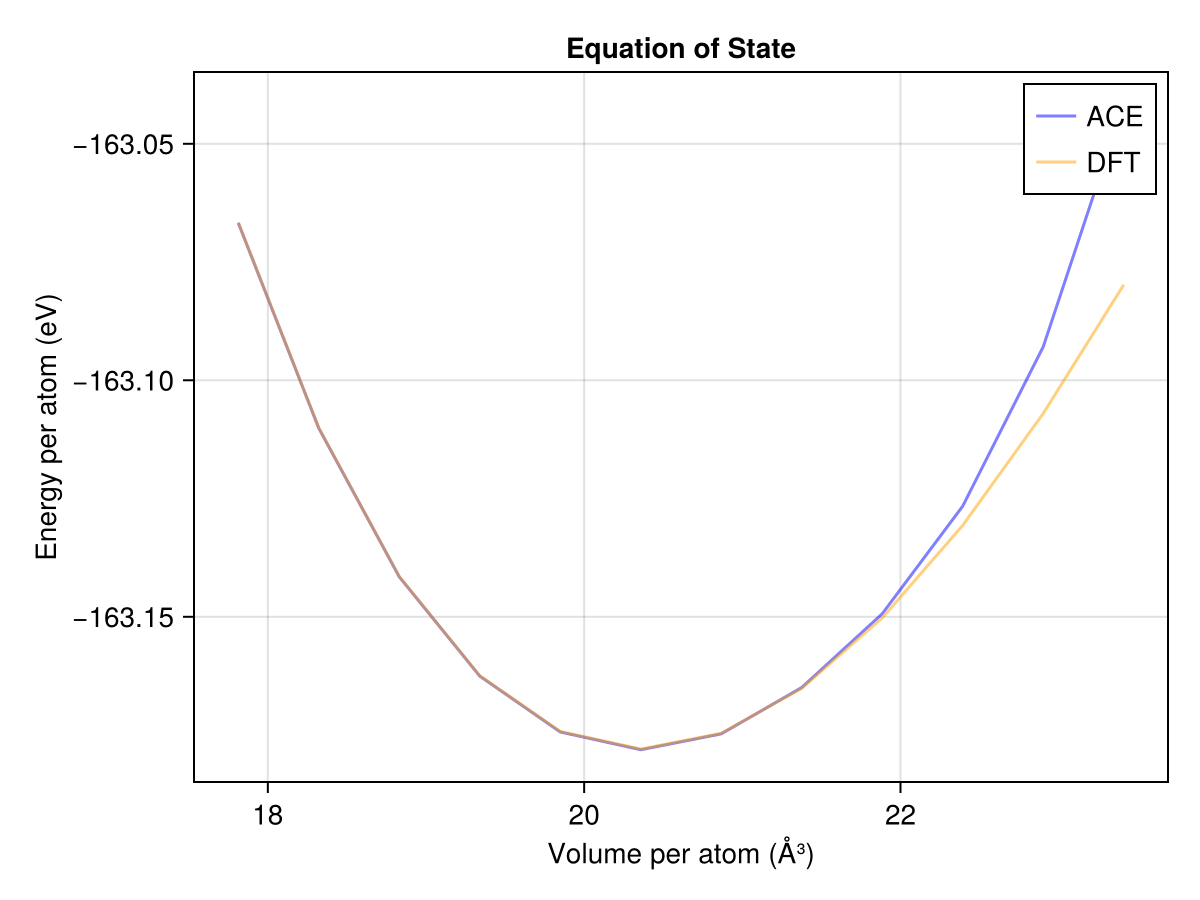

In [49]:
f1 = Figure()
ax1 = Axis(f1[1, 1], xlabel="Volume per atom (Å³)", ylabel="Energy per atom (eV)", title="Equation of State")
lines!(ax1, volumes_per_atom, energies_per_atom, label="ACE", color = :blue, alpha = 0.5)
lines!(ax1, gap_volumes, gap_energies, label="DFT", color = :orange, alpha = 0.5)
axislegend(ax1)
f1

In [50]:
bulk_committee = []
ace_v0_committee=[]
for i = 1:50
    coeffs_i, X_i = OLS(volumes_per_atom, co_energies_per_atom[:,i]; degree=2)
    ace_V0_i, ace_e0_i, ace_B_i     = QoI(coeffs_i)
    push!(bulk_committee, ace_B_i)
    push!(ace_v0_committee, ace_V0_i)
end 

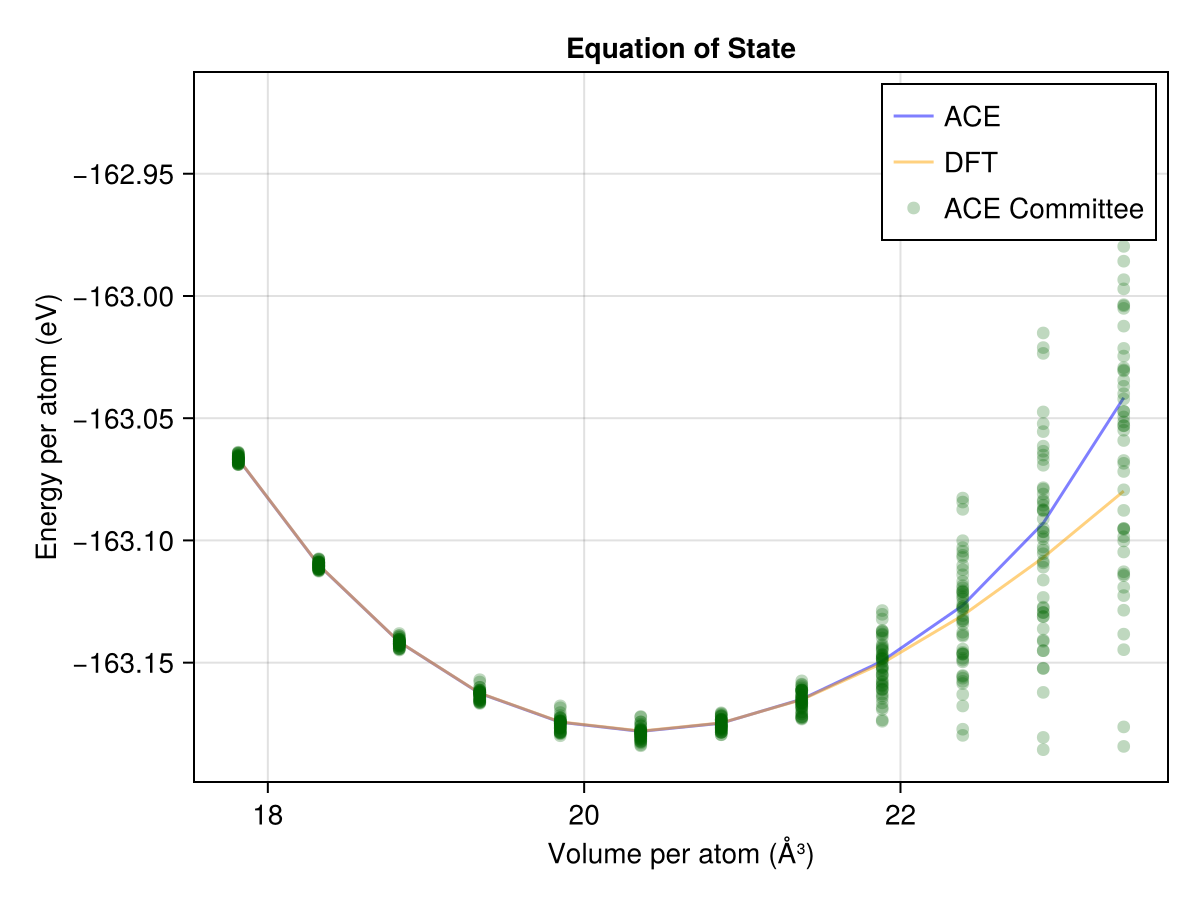

In [51]:
f2 = Figure()
ax2 = Axis(f2[1, 1], xlabel="Volume per atom (Å³)", ylabel="Energy per atom (eV)", title="Equation of State")
lines!(ax2, volumes_per_atom, energies_per_atom, label="ACE", color = :blue, alpha = 0.5)
lines!(ax2, gap_volumes, gap_energies, label="DFT", color = :orange, alpha = 0.5)
for i=1:50
    if (i == 1)
        scatter!(ax2, volumes_per_atom, co_energies_per_atom[:,i], label="ACE Committee", color = :darkgreen, alpha = 0.25)
    else
        scatter!(ax2, volumes_per_atom, co_energies_per_atom[:,i], color = :darkgreen, alpha = 0.25)
    end
end
axislegend(ax2)
f2

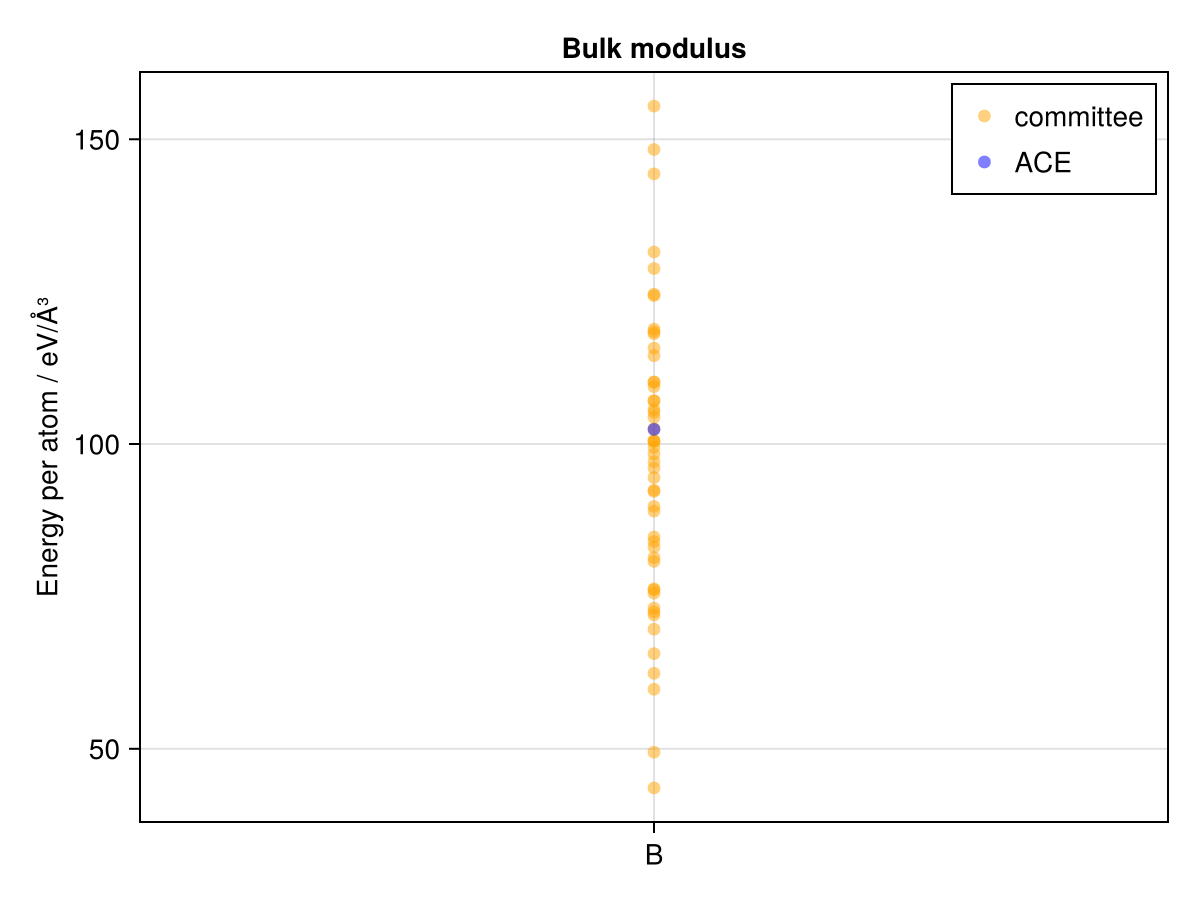

In [56]:
f2 = Figure()
xpos = 1:1
ax2 = Axis(f2[1, 1], xticks=(xpos, ["B"]), ylabel="Energy per atom / eV/Å³", title="Bulk modulus")

scatter!(ax2, fill(xpos[1], length(bulk_committee)), bulk_committee, label="committee", color = :orange, alpha = 0.5)
scatter!(ax2, 1, ace_B, label="ACE", color = :blue, alpha = 0.5)
axislegend(ax2)
f2